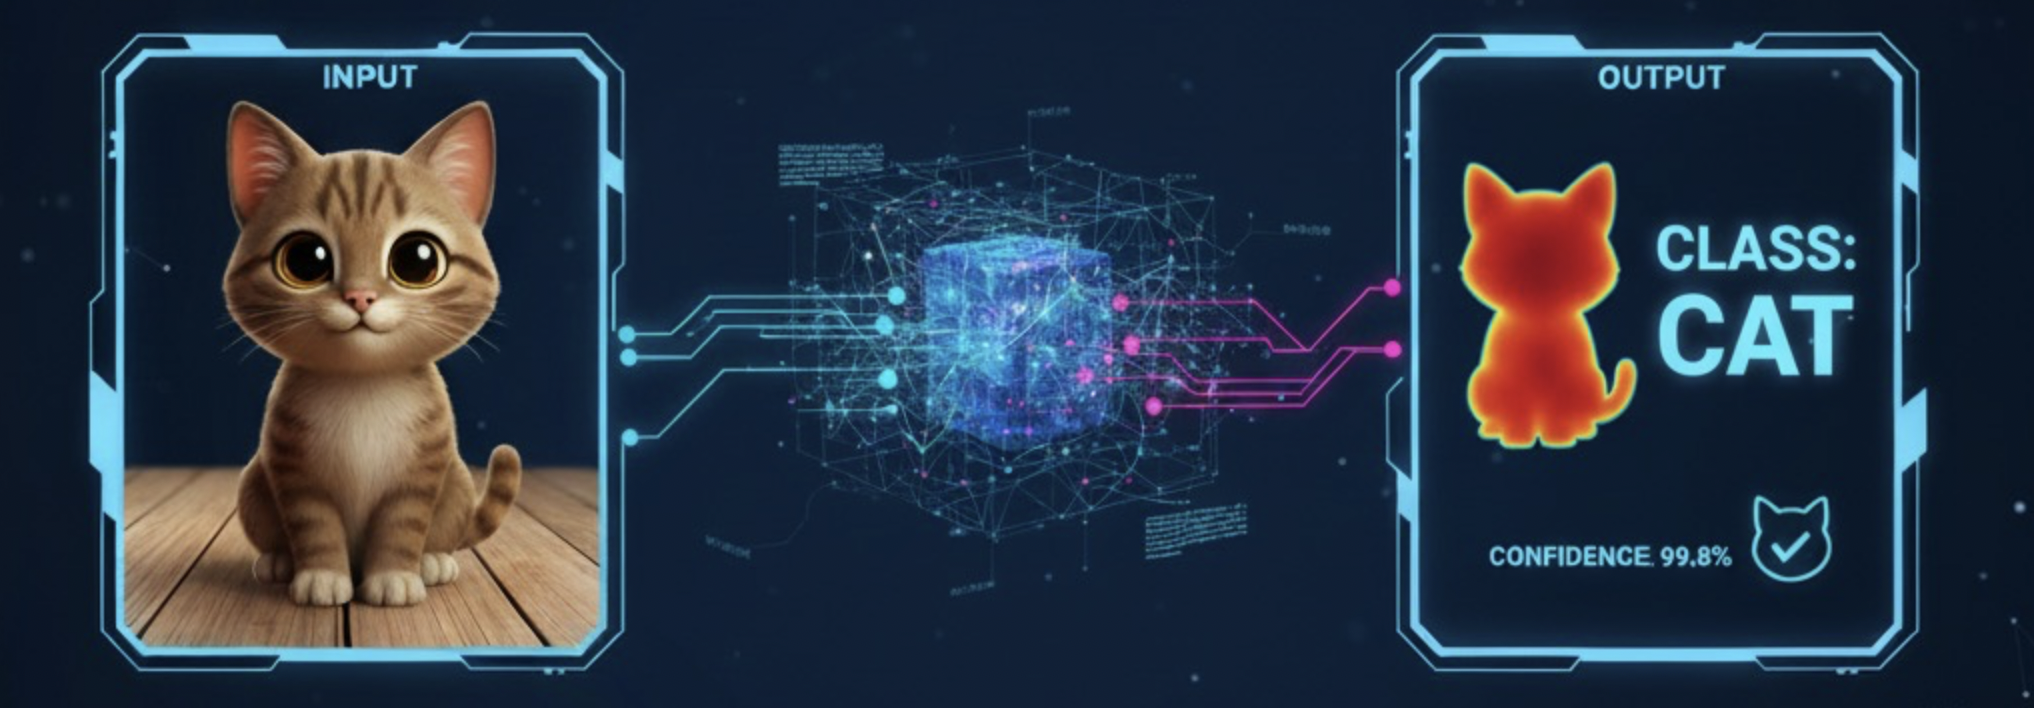

# Grad-CAM vizualizáció

A neurális hálók működése gyakran egy "fekete doboz", nehéz megérteni, hogy a modell pontosan **mire alapozza a döntéseit**.  
A **Grad-CAM (Gradient-weighted Class Activation Mapping)** egy vizualizációs technika, amely a kimeneti osztályhoz vezető gradiensek felhasználásával megmutatja, mely képrészletekre "figyelt" a hálózat a predikció során.  

Ebben a feladatban kapsz 5 képet, amelyek látszólag ugyanúgy néznek ki. A ResNet-18 előre betanított hálózatával kell prediktálnod rá, majd Grad-CAM-el megvizsgálni, hogy melyik a kakukktojás, ahol a modell rossz régióra figyelt.

Válaszodat a fájlnevekben szereplő szám formájában várjuk.

In [ ]:
%%capture
!gdown 1Y-4w2gym0nEJH2u_y02FNDSoJ5n4xiRj
!unzip -o -q /content/gradcam_cat.zip

In [ ]:
import json
import urllib.request

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models.resnet import ResNet18_Weights

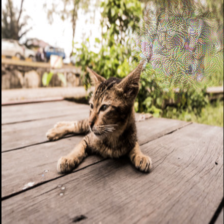

In [ ]:
img_path = '/content/02.png'
input_image = Image.open(img_path)
input_image

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()

In [ ]:
IMAGENET_MEAN_VALUES = [0.485, 0.456, 0.406]
IMAGENET_STD_VALUES = [0.229, 0.224, 0.225]

preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN_VALUES, std=IMAGENET_STD_VALUES),
    ]
)


In [ ]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

In [ ]:
logits = model(input_batch)

In [ ]:
probs = torch.softmax(logits, dim=1)
pred_class_idx = torch.argmax(probs, dim=1).item()
predicted_prob = probs[0, pred_class_idx].item()

In [ ]:
IMAGENET_CLASSES_URL = "https://raw.githubusercontent.com/jss367/files/main/imagenet_classes.json"
class_labels = json.loads(requests.get(IMAGENET_CLASSES_URL).text)

In [ ]:
predicted_class_name = class_labels[pred_class_idx]
print(f"Predicted class: {predicted_class_name} (index: {pred_class_idx}, probability: {predicted_prob:.2%})")

Predicted class: tabby cat (index: 281, probability: 93.59%)


In [ ]:
def find_last_conv_layer(model: nn.Module) -> tuple:
    last_conv_layer_name = None
    last_conv_layer = None

    for layer_name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            last_conv_layer_name = layer_name
            last_conv_layer = layer

    return last_conv_layer_name, last_conv_layer

In [ ]:
layer_name, target_layer = find_last_conv_layer(model)
print(layer_name)

layer4.1.conv2


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks for gradients and activations
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.full_backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def full_backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def compute_heatmap(self, input_batch, class_idx=None):
        # Forward pass
        logits = self.model(input_batch)
        self.model.zero_grad()

        if class_idx is None:
            class_idx = torch.argmax(logits, dim=1).item()

        # Compute gradients for the target class
        one_hot_output = torch.zeros_like(logits)
        one_hot_output[0, class_idx] = 1
        logits.backward(gradient=one_hot_output)

        # Compute Grad-CAM heatmap
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activations, dim=1, keepdim=True)
        heatmap = torch.relu(heatmap)  # ReLU removes negative values
        heatmap /= torch.max(heatmap)  # Normalize to [0, 1]

        # Get the predicted class probability
        probs = torch.softmax(logits, dim=1)
        predicted_prob = probs[0, class_idx].item()

        return heatmap.squeeze().cpu().numpy(), class_idx, predicted_prob

In [ ]:
gradcam = GradCAM(model, target_layer)

heatmap, predicted_class_idx, predicted_prob = gradcam.compute_heatmap(input_batch)

In [ ]:
def visualize_heatmap(img_path: str, heatmap: np.ndarray) -> None:
    # Read the image from the given file path
    img = cv2.imread(img_path)

    # Resize the heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap values to the range [0, 255] and cast to uint8
    heatmap = np.uint8(255 * heatmap)

    # Apply the JET colormap to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend the original image with the heatmap (60% original, 40% heatmap)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the blended image in RGB format
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

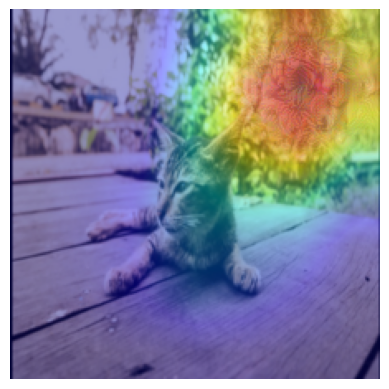

In [ ]:
visualize_heatmap(img_path, heatmap)